# Formatting the uploaded CSV 

## Import modules

In [92]:
import csv
import pandas as pd

## Function to filter the CSV file & Change to DataFrame in Pandas

Parameters:  <br>
file_name: the name of the file (in string) <br>

Variables: <br>
formatted: the csv file after filtering <br>
df: the DataFrame generated from the formatted csv file

In [93]:
def csv2df(file_name):

    '''filter the csv file & import to DataFrame'''
    my_file = open(file_name)
    formatted = open("formatted.csv","w",newline='')
    
    reader = csv.reader(my_file)
    formatted_csv = csv.writer (formatted)
    
    # Create a header in formatted.
    header = ['TimeStamp','TimeElapsed','Category','Acc-X','Acc-Y','Acc-Z']
    formatted_csv.writerow(header)
    
    # Start filtering
    for item in reader:
        if item[1] == 'acc':
            each_line = list(item)
            # Create a colomn for "TimeElapsed" later
            each_line.insert(1,0)
            formatted_csv.writerow(each_line)
            
    # change to Dataframe in pandas
    df = pd.read_csv('formatted.csv',header = 0)   
    
    # "TimeElapsed colomn"
    startTime = df.iloc[0,0]
    for i in range(len(df)):
        df.iloc[i,1]=(df.iloc[i,0]-startTime)/1000

    return df

# DataFrame Manipulation

## Function to generate Time Interval

In [94]:
def timeInterval(df):
    '''calculate time interval from the TimeElpased colomn'''
    
    #index of TimeInterval: 6
    timeInterval = [0]
    for i in range (1,len(df)):
        timeInterval.append(df.iloc[i,1]-df.iloc[i-1,1])
        
    df["TimeInterval"]=timeInterval

## Function to generate Acc-Y-Adjusted

Variable: <br>
shift_value: the value to shift all acceleration values 
<p> in this application, the shift value from the experiment results, is approximately to be (initial accelration)/2</p>

In [95]:
def accAdjust(df):
    '''Generate the Acc-Y-Adjusted and take the shift value into account'''
    
    #index of Acc-Y-Adjusted: 7
    acc_Y = []
    for i in range(len(df)):
        acc_Y.append(-df.iloc[i,4]*9.8)
        
    df["Acc-Y-Adjusted"] = acc_Y
    
    #shift value
    shift_value = df.iloc[0,7]/2
    for i in range(len(df)):
        df.iloc[i,7] = df.iloc[i,7] - shift_value

## Function to generate V-btw2

In [96]:
def dv(df):
    '''Generate the d_v using the definition of integration using the Acc-Y-Adjusted values'''
    
    #index of V-btw2: 8
    d_v = [0]
    for i in range (1,len(df)):
        velocity_each = 0.5*(df.iloc[i,7]+df.iloc[i-1,7])*df.iloc[i,6] #index7: Acc-Y-Adjusted, index6: TimeInterval
        d_v.append(velocity_each)
    
    df["V-btw2"]=d_v

## Function to generate V(t)

In [97]:
def vt(df):
    '''Generate the v(t) colomn to record the instantanious velocity in any data point'''
    
    #index of V(t): 9
    false_list = [0]*len(df)
    df["V(t)"] = false_list
    
    for i in range(1,len(df)):
    # index8: V-btw2
        ins_v = df.iloc[i,8]+df.iloc[i-1,9]
        df.iloc[i,9] = ins_v

## Function to generate S-btw2

In [98]:
def ds(df):
    '''Generate the d_s using the definition of integration using the V(t) values'''
    
    #index of S-btw2: 10
    d_s = [0]
    for i in range (1,len(df)):
        # index9: v(t), index6: TimeInterval
        displacement_each = 0.5*(df.iloc[i,9]+df.iloc[i-1,9])*df.iloc[i,6]
        d_s.append(displacement_each)
        
    df["S-btw2"] = d_s

## Function to generate S(t)

In [99]:
def st(df):
    '''Generate the s(t) colomn to record the instantanious displacement in any data point'''
    
    #index of V(t): 11
    false_list = [0]*len(df)
    df["S(t)"] = false_list
    
    for i in range(1,len(df)):
        # index10: S-btw2
        ins_v = df.iloc[i,10]+df.iloc[i-1,11]
        df.iloc[i,11] = ins_v

## Function to integrate all the above functions

In [100]:
def dfFormat(df):
    timeInterval(df)
    accAdjust(df)
    dv(df)
    vt(df)
    ds(df)
    st(df)
    
    return df

# Physical Property Determination

## Total Distance Travelled

In [101]:
def distance(df):
    '''Get the total distance travelled'''
    
    Total_Distance_Travelled = max(df["S(t)"])
    
    return Total_Distance_Travelled

## Total Time Taken

In [102]:
def totalTime(df):
    '''Get the total time taken'''
    
    Total_Time_Taken = df.iloc[len(df)-1,1]
    
    return Total_Time_Taken

## Max Velocity

In [103]:
def maxVelocity(df):
    '''Get the max velocity'''
    
    Max_Velocity = max(df["V(t)"])
    
    return Max_Velocity

## Acceleration Cut-off Time & Average Acceleration

Variables: <br>
negative_acc_list: a list of the index of which the acceleration value is nagetive

In [104]:
def acc(df):
    '''Get the cut-off time for acceleration & Average Acceleration'''
    
    negative_acc_list = df[df["Acc-Y-Adjusted"] < 0].index.tolist()
    # To avoid early cut-off
    # set the threshhold to be 1/4 of total journey
    while negative_acc_list[0] < 0.25*len(df):
        negative_acc_list = negative_acc_list[1:]
        
    CutOff_Time = df.iloc[negative_acc_list[0],1]
    
    cutoff_idx = negative_acc_list[0]
    acc_list = []
    for i in range(cutoff_idx):
        acc_list.append(df.iloc[i,7])
    Average_Acceleration = sum(acc_list)/len(acc_list)
    
    return CutOff_Time, Average_Acceleration

## Max Acceleration

In [105]:
def maxAcc(df):
    '''Get the maxium Acceleration'''
    
    Max_Acceleration = max(df["Acc-Y-Adjusted"])

    return Max_Acceleration

## Function to integrate the above all functions

In [106]:
def data(df):
    Total_Distance_Travelled = distance(df)
    Total_Time_Taken = totalTime(df)
    Max_Velocity = maxVelocity(df)
    CutOff_Time, Average_Acceleration = acc(df)
    Max_Acceleration = maxAcc(df)
    
    result_data = f'''
    # Tital distance travelled: {Total_Distance_Travelled} m
    # Total time taken: {Total_Time_Taken} s
    # Max velocity: {Max_Velocity} m/s
    # Cut-off time for acceleration: {CutOff_Time} s
    # Average acceleration: {Average_Acceleration} m/s^2
    # Max acceleration: {Max_Acceleration} m/s^2
    '''
    
    return result_data

# Integrate Above all

In [107]:
def printData():
    file_name = input("Please input the csv file name: ")
    
    df = csv2df(file_name)
    df = dfFormat(df)
    result_data = data(df)
    
    print(result_data)


In [108]:
printData()

Please input the csv file name: UC_EXPO_first.csv

    # Tital distance travelled: 458.69872813257456 m
    # Total time taken: 70.843 s
    # Max velocity: 12.487912561600005 m/s
    # Cut-off time for acceleration: 17.717 s
    # Average acceleration: 0.6989922122222224 m/s^2
    # Max acceleration: 1.1632457900000002 m/s^2
    


# Graphing and Saving

In [109]:
import matplotlib.pyplot as plt

## Graph title

After running the following cell, error will raise, but it does not matter because we will include the statement later

In [110]:
title = file_name.split('.')[0]

NameError: name 'file_name' is not defined

In [111]:
def mkdir_p(mypath):
    '''Creates a directory. equivalent to using mkdir -p on the command line'''

    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

In [112]:
output_dir = "Graphs"
mkdir_p(output_dir)

## Graph a-t

In [113]:
def plotAcc(df,title,CutOff_Time):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
    axes.set_xlabel('time (s)')
    axes.set_ylabel('Acceleration_y (m/s^2)', color='tab:blue')
    
    t=df["TimeElapsed"]
    acc_y=df["Acc-Y-Adjusted"]
    axes.plot(t,acc_y,color="red", lw=2, ls='-')
    axes.axvline(CutOff_Time, 0, 1, label='Cut-off for acceleration')
    axes.axhline(0, color='black')
    axes.legend()
    axes.title.set_text(title)
    
    name = title + '-'+ 'Acceleration'
    output_dir = "Graphs"
    plt.savefig(f'{output_dir}/{name}.png')

## Graph v-t

In [114]:
def plotVelocity(df,title,Max_Velocity):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
    axes.set_xlabel('time (s)')
    axes.set_ylabel('Velocity (m/s)', color='tab:blue')
    
    t=df["TimeElapsed"]
    v=df["V(t)"]
    axes.plot(t,v,color="red", lw=2, ls='-')
    axes.axhline(Max_Velocity, 0, 1, label='Max Velocity')
    
    axes.legend()
    axes.title.set_text(title)
    
    name = title + '-'+ 'Velocity'
    output_dir = "Graphs"
    plt.savefig(f'{output_dir}/{name}.png')

## Graph s-t

In [115]:
def plotDisplacement(df,title,Total_Distance_Travelled):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
    axes.set_xlabel('time (s)')
    axes.set_ylabel('Displacement (m)', color='tab:blue')
    
    t=df["TimeElapsed"]
    s=df["S(t)"]
    axes.plot(t,s,color="red", lw=2, ls='-')
    axes.axhline(Total_Distance_Travelled, 0, 1, label='Total Distance Travelled')
    
    axes.legend()
    axes.title.set_text(title)
    
    name = title + '-'+ 'Displacement'
    output_dir = "Graphs"
    plt.savefig(f'{output_dir}/{name}.png')

## Function to integrate the above plotting functions

In [116]:
def plot():
    file_name = input("Please input the csv file name: ")
    title = file_name.split('.')[0]
    df = csv2df(file_name)
    df = dfFormat(df)
    
    Total_Distance_Travelled = distance(df)
    Max_Velocity = maxVelocity(df)
    CutOff_Time, Average_Acceleration = acc(df)
    
    output_dir = "Graphs"
    mkdir_p(output_dir)
    
    plotAcc(df,title,CutOff_Time)
    plotVelocity(df,title,Max_Velocity)
    plotDisplacement(df,title,Total_Distance_Travelled)

Please input the csv file name: UC_EXPO_first.csv


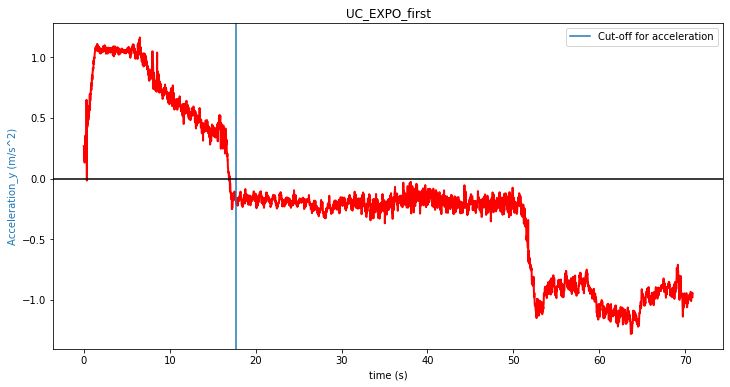

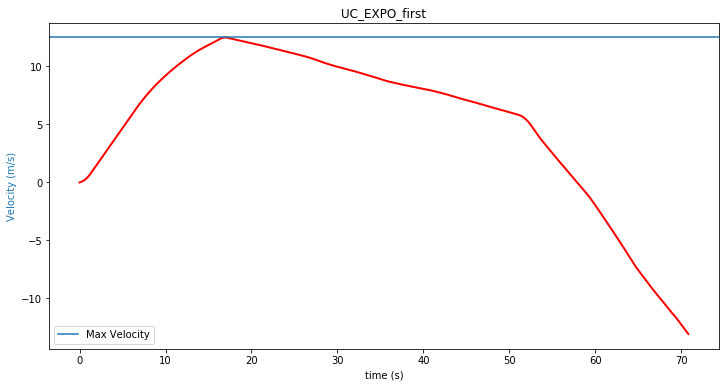

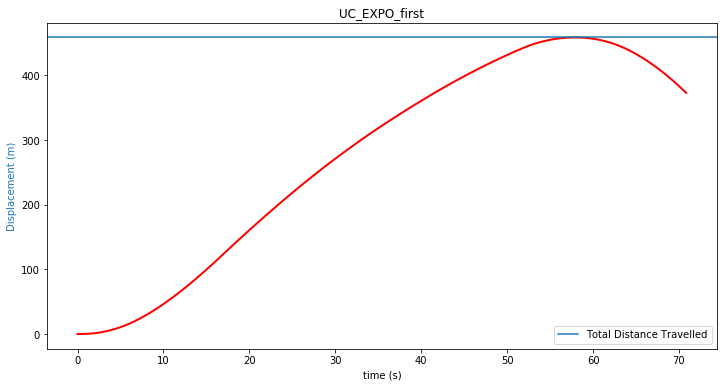

In [117]:
plot()

# Include Above All (printData() & plot())

In [118]:
def run():
    file_name = input("Please input the csv file name: ")
    title = file_name.split('.')[0]
    
    df = csv2df(file_name)
    df = dfFormat(df)
    Total_Distance_Travelled = distance(df)
    Max_Velocity = maxVelocity(df)
    CutOff_Time, Average_Acceleration = acc(df)
    
    #print data
    result_data = data(df)
    print(title)
    print(result_data)
    
    #plot data
    output_dir = "Graphs"
    mkdir_p(output_dir)
    
    plotAcc(df,title,CutOff_Time)
    plotVelocity(df,title,Max_Velocity)
    plotDisplacement(df,title,Total_Distance_Travelled)

Please input the csv file name: UC_EXPO_first.csv
UC_EXPO_first

    # Tital distance travelled: 458.69872813257456 m
    # Total time taken: 70.843 s
    # Max velocity: 12.487912561600005 m/s
    # Cut-off time for acceleration: 17.717 s
    # Average acceleration: 0.6989922122222224 m/s^2
    # Max acceleration: 1.1632457900000002 m/s^2
    


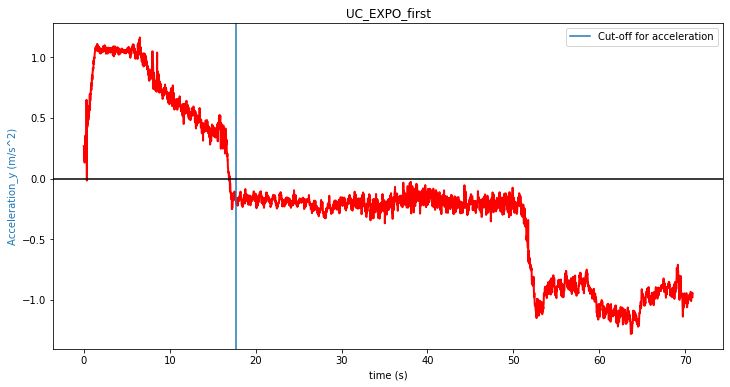

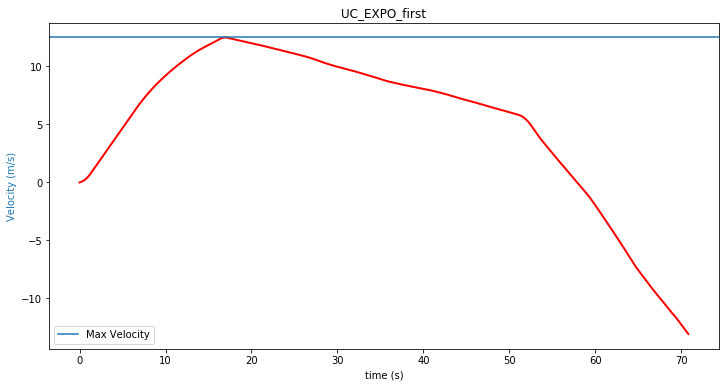

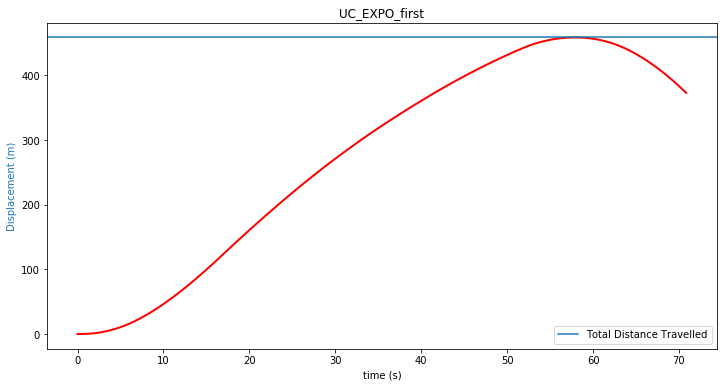

In [119]:
run()